# Computing RADAR Cube

To use this script, you must have the RaDICaL dataset and its SDK. If you don't already have them, please download using the following cell

In [ ]:
!wget https://fireball.teckyianlim.me/file/flaming-cake/indoor_sample_50.h5
!python -m pip install git+https://github.com/moodoki/radical_sdk.git

Importing required libraries

In [2]:
from radicalsdk.h5dataset import H5DatasetLoader
from radicalsdk.radar.config_v1 import read_radar_params
from radicalsdk.radar.v1 import RadarFrame
import matplotlib.pyplot as plt
import numpy as np

2025-05-06 13:34:49.929970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 13:34:51.880375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Loading data

Load data configuration

In [3]:
# Load dataset
data = H5DatasetLoader('indoor_sample_50.h5')
frame_idx = 1 # Select frame to visualize

# Load radar config
CONFIG_PATH = 'radarcfg/indoor_human_rcs.cfg'
radar_config = read_radar_params(CONFIG_PATH)
print(radar_config) # print RADAR config on command line

with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])

{'numLanes': 4, 'rx4': True, 'rx3': True, 'rx2': True, 'rx1': True, 'numTx': 2, 'tx3': True, 'tx2': False, 'tx1': True, 'isComplex': True, 'image_band': False, 'profiles': [{'id': 0, 'start_frequency': 77000000000.0, 'idle': 5.8e-05, 'adcStartTime': 7e-06, 'rampEndTime': 3.9999999999999996e-05, 'txPower': 0.0, 'txPhaseShift': 0.0, 'freqSlopeConst': 100000000000000.0, 'txStartTime': 1e-06, 'adcSamples': 304, 'adcSampleRate': 9499000.0, 'hpfCornerFreq1': 0, 'hpfCornerFreq2': 0, 'rxGain': 30.0}], 'chirps': [{'chirpStartIndex': 0, 'chirpStopIndex': 0, 'profileID': 0, 'startFreqVariation': 0.0, 'slopeVariation': 0.0, 'idleVariation': 0.0, 'adcStartVariation': 0.0, 'chirptx3': False, 'chirptx2': False, 'chirptx1': True}, {'chirpStartIndex': 1, 'chirpStopIndex': 1, 'profileID': 0, 'startFreqVariation': 0.0, 'slopeVariation': 0.0, 'idleVariation': 0.0, 'adcStartVariation': 0.0, 'chirptx3': True, 'chirptx2': False, 'chirptx1': False}], 'numChirps': 64, 'fps': 30.00030000300003, 'adcPower': 'reg

Load current frame

In [4]:
current_radar_frame = data['radar'][frame_idx]
rf = RadarFrame(radar_config)
print(current_radar_frame.shape)

(32, 8, 304)


As we have shape (32, 8, 304), this means that it corresponds to bins (chirps, antennas, samples).

These will be used to compute, in this order:

1. **Sample** → **Range**
2. **Chirp** → **Doppler**
3. **Antenna** → **Angle**

We are assessing the frame with the following picture from the camera:

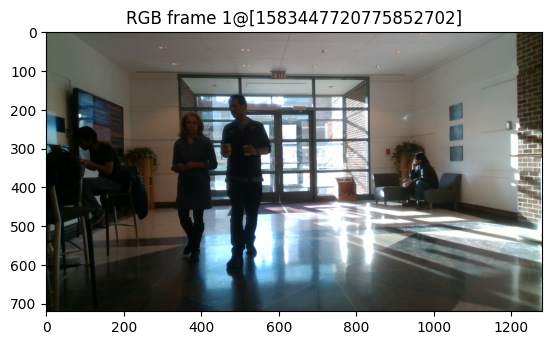

In [5]:
plt.figure()
plt.imshow(data['rgb'][frame_idx][..., ::-1])
plt.title(f'RGB frame {frame_idx}@{data["rgb_timestamp"][frame_idx]}')
plt.show()

## 2. Computing resolutions to determine units

Computing range units

In [6]:
# speed of wave propagation
c = 299792458 # m/s
# compute ADC sample period T_c in msec
adc_sample_period = 1 / adc_sample_rate * num_adc_samples # msec
# next compute the Bandwidth in GHz
bandwidth = adc_sample_period * chirp_slope # GHz
# Coompute range resolution in meters
range_resolution = c / (2 * (bandwidth * 1e9)) # meters
# Compute max range
max_range = range_resolution * num_adc_samples

# Calculate change in range data labels
ranges = np.arange(0, max_range + range_resolution, range_resolution)
range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

Computing doppler units

In [7]:
# extract number of chirps
num_chirps = current_radar_frame.shape[0]
# compute center frequency in GHz
center_freq = (77 + bandwidth/2) # GHz
# compute center wavelength 
lmbda = c/(center_freq * 1e9) # meters
# interval for an entire chirp including deadtime
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec
# compute doppler resolution
doppler_resolution = lmbda / (2 * num_chirps * num_tx * chirp_interval)
# compute max doppler reading
max_doppler = num_chirps * doppler_resolution / 2 # m/s

# Calculate change in doppler data labels
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
doppler_tick_labels = dopplers[::len(dopplers)//10][::-1].round(2)


Computing angle units

## 3. Computing RADAR cube with FFTs

### a. Correct computation

Computing FFTs with shift in doppler and angle dimensions

In [8]:
# Range FFT
range_fft = np.fft.fft(current_radar_frame, axis=2)

# Doppler FFT
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=0), axes=0)

# Angle FFT
padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft, axis=1), axes=1)

radar_cube = azimuth_fft

### b. Alternatives

Computing FFTs with shift in the angle dimension only

In [9]:
# Range FFT
range_fft = np.fft.fft(current_radar_frame, axis=2)

# Doppler FFT
doppler_fft = np.fft.fft(range_fft, axis=0)

# Angle FFT
padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft, axis=1), axes=1)

radar_cube_no_doppler_shift = azimuth_fft

Computing FFTs only in range and doppler dimensions

In [10]:
# Range FFT
range_fft = np.fft.fft(current_radar_frame, axis=2)

# Doppler FFT
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=0), axes=0)

radar_cube_no_azimuth_fft = doppler_fft

## 4. Visualizations experiments

### a. Visualizing the effect of using fftshift on the doppler fft 

The data originally at 0 →-> data at 16 (and equivalently for the rest of the cube, meaning that all of the data gets shifted by 16 in the doppler axis)

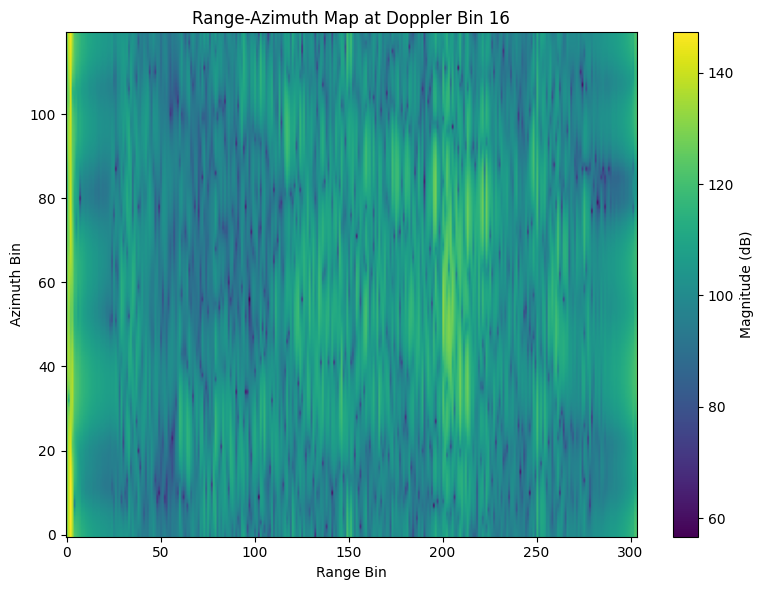

In [11]:
doppler_bin = 16  # Pick any valid dop bin

# Get a 2D slice: Azimuth vs Range at this doppler bin
slice_data = radar_cube[doppler_bin, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(20 * np.log10(np.abs(slice_data)),
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Azimuth Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()


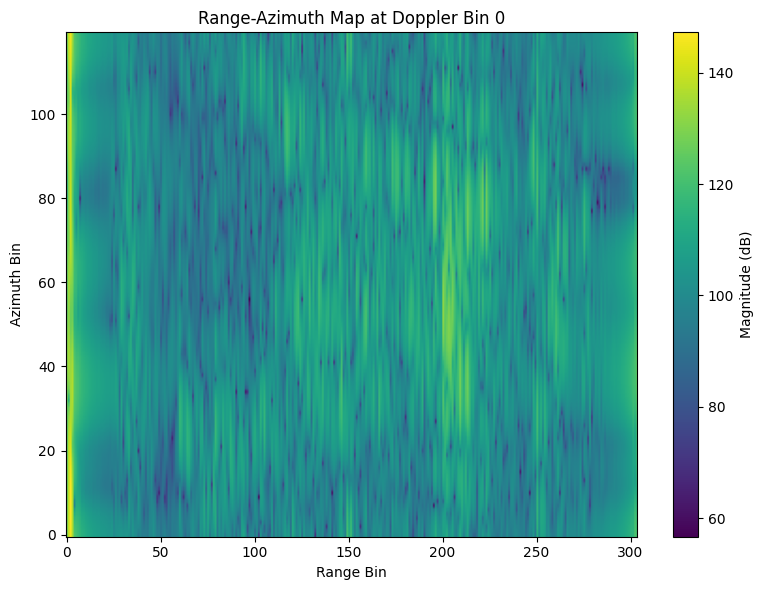

In [12]:
doppler_bin = 0  # Pick any valid doppler bin

# Get a 2D slice: Azimuth vs Range at this doppler bin
slice_data = radar_cube_no_doppler_shift[doppler_bin, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(20 * np.log10(np.abs(slice_data)),
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Azimuth Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()

As we have negative and positive velocities, we do indeed want the zero bin to be in the middle

### b. Visualizing effect of summing vs. taking the mean over the dimensions being collapsed

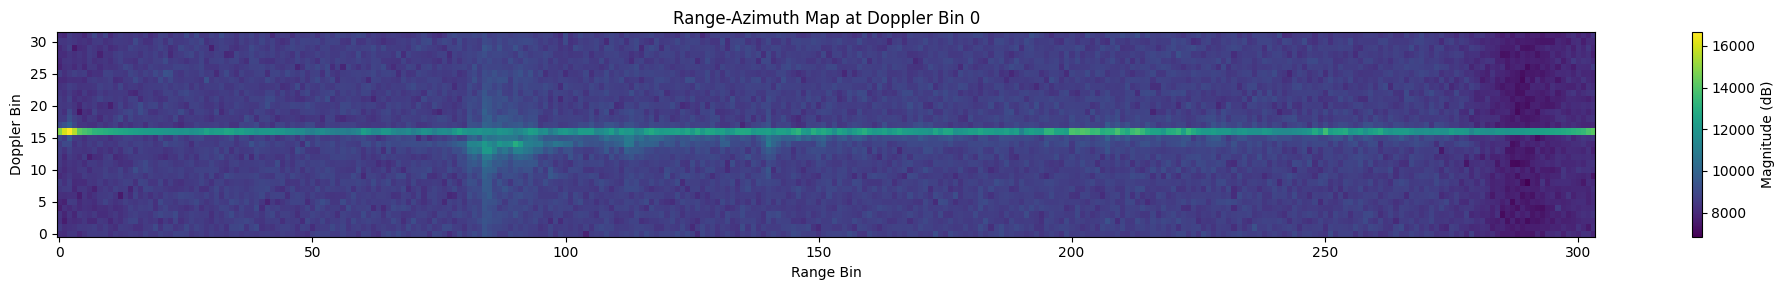

In [13]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.sum(20 * np.log10(np.abs(radar_cube)), axis=1)  # Sum over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()

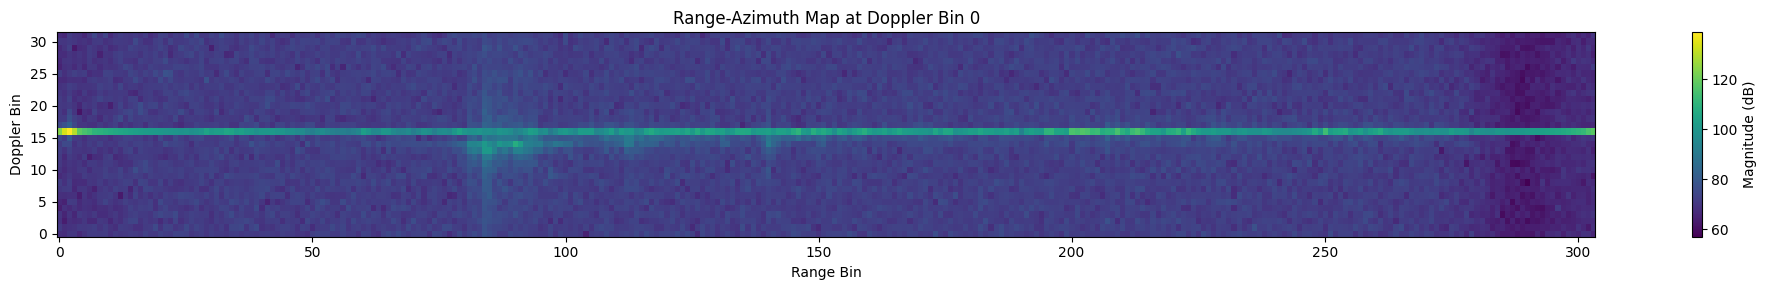

In [14]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.mean(20 * np.log10(np.abs(radar_cube)), axis=1)  # Sum over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()

range, diazimuth and doppler values being correct for our cube cropping, the actual magnitude of the intneeonly about range, azimuth and doppler values being correct for our cube cropping,  actualis not of much importance.

It also doesn't really matter whether you take the sum or mean over the azimuth dimensions with or without FFT. The ones above are with FFT over that dimensions, and the one below without:

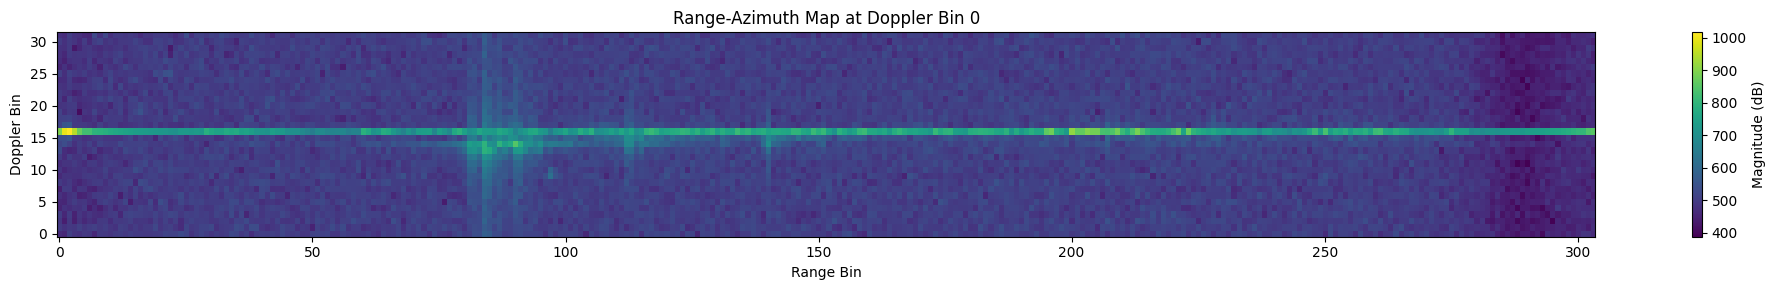

In [15]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.sum(10 * np.log10(np.abs(radar_cube_no_azimuth_fft)**2), axis=1)  # Sum over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()

Once again, only the magnitues change significantly. However, you do still see some higher intensities for a few parts, but things remain mostly the same.

## 5. Final Visualizations

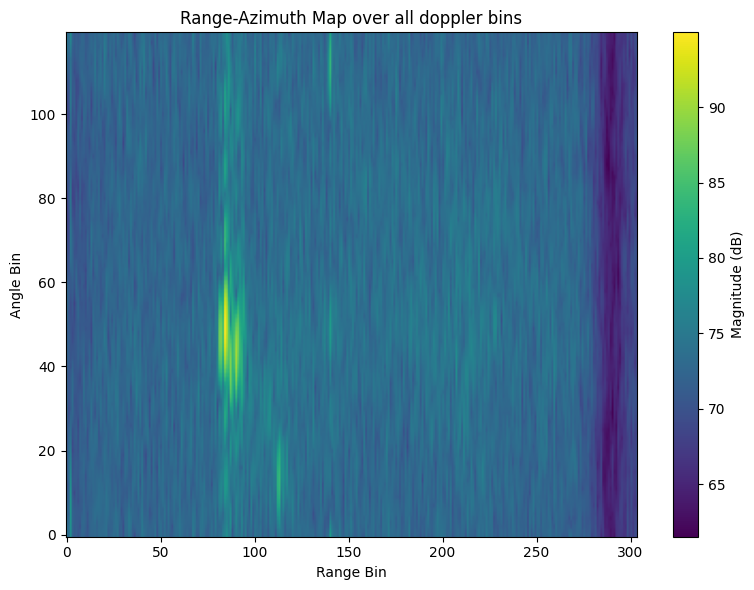

In [16]:
# Collapse data into a 2D slice, collapsing over the doppler dimension
collapsed_range_doppler = np.mean(20 * np.log10(np.abs(radar_cube)), axis=0)  # Sum over doppler dimension

plt.figure(figsize=(8, 6))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Angle Bin')
plt.title(f'Range-Azimuth Map over all doppler bins')
plt.tight_layout()
plt.show()

Index of maximum intensity in the doppler axis is the velocity

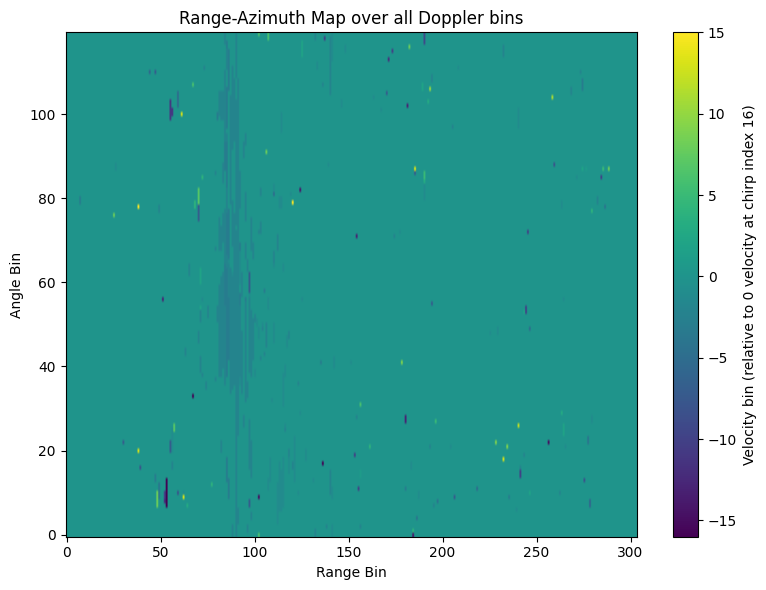

In [17]:
# Collapse data into a 2D slice by taking the index of the max magnitude over the Doppler dimension
collapsed_range_doppler = np.argmax(np.abs(radar_cube), axis=0)

# Shift indices: index 16 -> 0 velocity, below -> negative, above -> positive
velocity_bins = collapsed_range_doppler - 16

plt.figure(figsize=(8, 6))
plt.imshow(velocity_bins, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Velocity bin (relative to 0 velocity at chirp index 16)')
plt.xlabel('Range Bin')
plt.ylabel('Angle Bin')
plt.title('Range-Azimuth Map over all Doppler bins')
plt.tight_layout()
plt.show()

Adding correct units

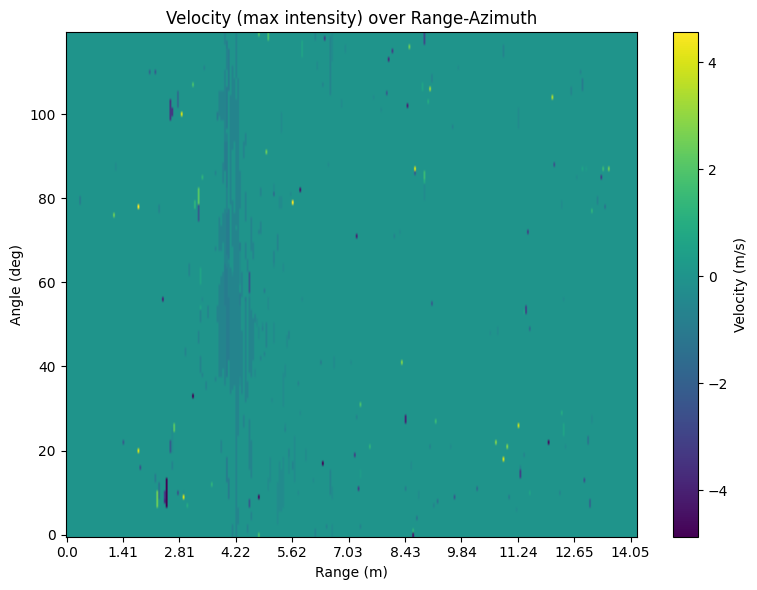

In [18]:
# Collapse to bin indices
collapsed_range_doppler = np.argmax(np.abs(radar_cube), axis=0)

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_range_doppler_velocity = dopplers[collapsed_range_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_range_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Testing with velocities = 0

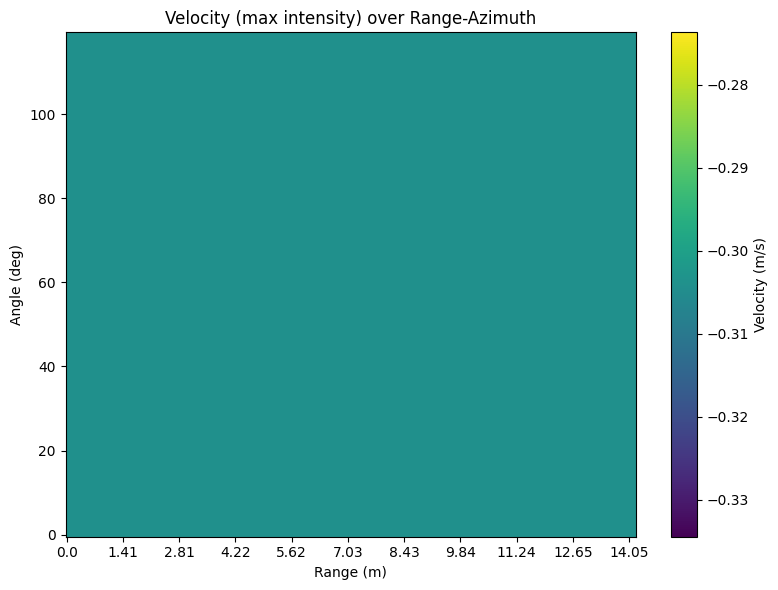

In [19]:
# Collapse to bin indices
collapsed_range_doppler = np.argmax(np.abs(radar_cube), axis=0)
collapsed_range_doppler = np.ones_like(collapsed_range_doppler)*15

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_range_doppler_velocity = dopplers[collapsed_range_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_range_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Testing with velocities = max

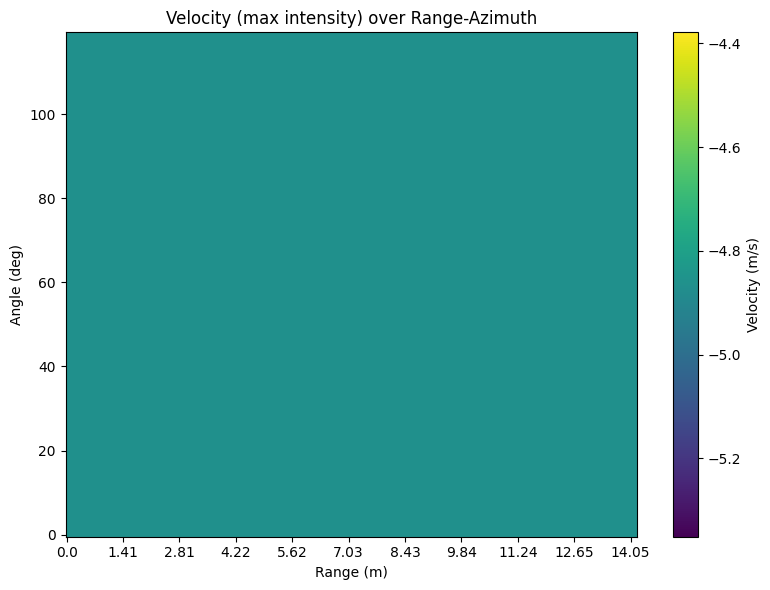

In [20]:
# Collapse to bin indices
collapsed_range_doppler = np.argmax(np.abs(radar_cube), axis=0)
collapsed_range_doppler = np.zeros_like(collapsed_range_doppler)

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_range_doppler_velocity = dopplers[collapsed_range_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_range_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Visualizing the full RADAR cube

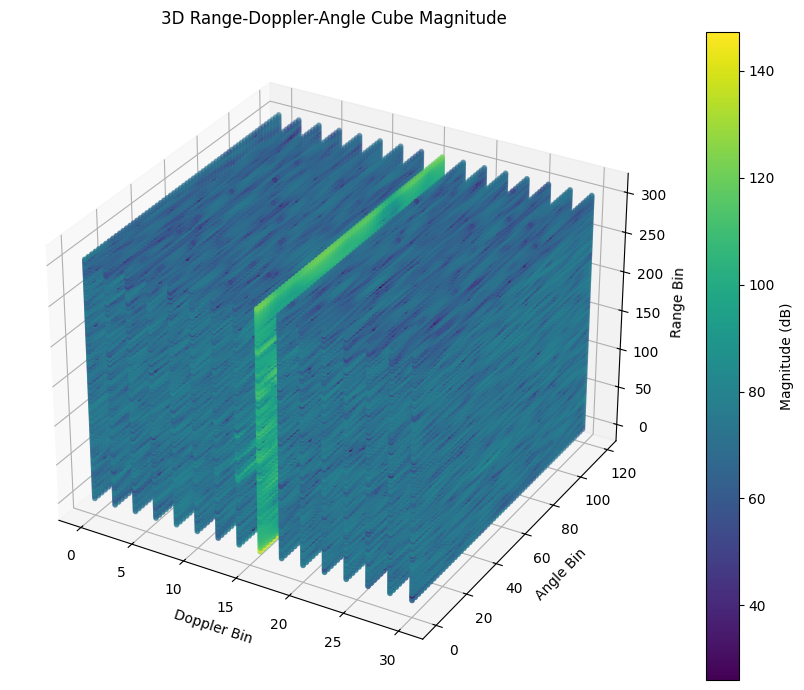

In [21]:
doppler_bins, angle_bins, range_bins = radar_cube.shape

# We'll downsample the data to avoid overcrowding the plot (optional)
downsample = 2
R, D, A = np.meshgrid(np.arange(0, doppler_bins, downsample),
                      np.arange(0, angle_bins, downsample),
                      np.arange(0, range_bins, downsample),
                      indexing='ij')

# Get the magnitude in dB
magnitude = 20 * np.log10(np.abs(radar_cube[::downsample, ::downsample, ::downsample]) + 1e-6)

# Flatten for scatter plotting
R_flat = R.flatten()
D_flat = D.flatten()
A_flat = A.flatten()
mag_flat = magnitude.flatten()

# Plot only points above a magnitude threshold to avoid clutter
threshold_dB = -40  # You can adjust this for clearer plots
mask = mag_flat > threshold_dB

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(R_flat[mask], D_flat[mask], A_flat[mask],
               c=mag_flat[mask], cmap='viridis', s=10)

ax.set_xlabel('Doppler Bin')
ax.set_ylabel('Angle Bin')
ax.set_zlabel('Range Bin')
fig.colorbar(p, label='Magnitude (dB)')
plt.title('3D Range-Doppler-Angle Cube Magnitude')
plt.tight_layout()
plt.show()

## 6. Videos

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

output_folder = "radar_frames"
os.makedirs(output_folder, exist_ok=True)

for frame_idx in range(data['radar'].shape[0]):

    # --- RADAR PROCESSING ---

    # Load radar frame
    current_radar_frame = data['radar'][frame_idx]
    rf = RadarFrame(radar_config)

    # Range FFT
    range_fft = np.fft.fft(current_radar_frame, axis=2)

    # Doppler FFT
    doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=0), axes=0)

    # Angle FFT
    padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
    azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft, axis=1), axes=1)

    radar_cube = azimuth_fft

    # --- COLLAPSE TO VELOCITY ---

    collapsed_range_doppler = np.argmax(np.abs(radar_cube), axis=0)

    dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

    # Convert bin indices to velocities
    collapsed_range_doppler_velocity = dopplers[collapsed_range_doppler]

    # --- COLLAPSE TO POWER (dB) ---

    collapsed_range_doppler_db = np.mean(20 * np.log10(np.abs(radar_cube) + 1e-6), axis=0)  # Avoid log(0)

    # --- PLOTTING ---

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 1️. Radar velocity plot
    im0 = axs[0].imshow(collapsed_range_doppler_velocity, 
                        aspect='auto', 
                        origin='lower', 
                        cmap='viridis',
                        vmin=-max_doppler, 
                        vmax=max_doppler + doppler_resolution)

    axs[0].set_xticks(range_ticks)
    axs[0].set_xticklabels(range_tick_labels)
    axs[0].set_xlabel('Range (m)')
    axs[0].set_ylabel('Angle (deg)')
    axs[0].set_title('Velocity (max intensity)')

    cbar = plt.colorbar(im0, ax=axs[0])
    cbar.set_label('Velocity (m/s)')

    # 2️. RGB image plot
    axs[1].imshow(data['rgb'][frame_idx][..., ::-1])  # Assuming RGB is BGR
    axs[1].axis('off')
    axs[1].set_title('RGB Image')

    # 3. Power map (dB)
    im2 = axs[2].imshow(collapsed_range_doppler_db,
                        aspect='auto',
                        origin='lower',
                        cmap='plasma')

    axs[2].set_xticks(range_ticks)
    axs[2].set_xticklabels(range_tick_labels)
    axs[2].set_xlabel('Range (m)')
    axs[2].set_ylabel('Angle (deg)')
    axs[2].set_title('Mean Power (dB)')

    # No colorbar as you requested

    plt.suptitle(f'Frame {frame_idx}', fontsize=16)
    plt.tight_layout()

    # Save the figure
    filename = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
    plt.savefig(filename)
    plt.close()  # Close the figure to save memory


In [ ]:
!ffmpeg -r 5 -i radar_frames/frame_%04d.png -vcodec libx264 -pix_fmt yuv420p radar_video.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab